<a href="https://colab.research.google.com/github/alaeddinehamroun/Recommender-Systems/blob/main/Content_based_filtering_on_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Content-based filtering** is a technique used by recommendation systems to provide personalized recommendations to users based on their preferences and past behavior. It works by analyzing the characteristics or features of items and creating a user profile based on their past interactions with the system.

The content-based filtering approach relies on the assumption that if a user likes a particular item, they are likely to enjoy other items that share similar attributes or features. For example, if a user enjoys watching action movies, the system will recommend other action movies based on the attributes of the movies they have previously watched, such as the genre, actors, and directors.

The process of content-based filtering involves extracting relevant features from the items, such as keywords, genre, actors, and directors. The system then compares the features of the items with the user's preferences and generates a list of recommendations based on the similarity between the user profile and item profiles.

One of the advantages of content-based filtering is that it is able to recommend items based on the specific interests of the user, even if the items are not popular among the majority of users. It is also able to provide recommendations in the absence of data on other users' preferences.

However, content-based filtering has limitations, such as the inability to recommend items that are outside the user's past behavior or preferences. It also requires accurate and relevant item attributes to create accurate item profiles, which can be challenging for certain types of items.

# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack, csr_matrix
import math

# Load the data

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2023-04-10 21:50:37--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  31.0MB/s    in 0.2s    

2023-04-10 21:50:38 (31.0 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [2]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [5]:
movies_file = "/content/ml-1m/movies.dat"
ratings_file = "/content/ml-1m/ratings.dat"
movies_cols = ["movie_id", "title", "genres"]
ratings_cols = ["user_id", "movie_id", "rating", "timestamp"]

# Read the files into DataFrames
movies = pd.read_csv(movies_file, sep="::", header=None, names=movies_cols, encoding='ISO-8859-1', engine='python')
ratings = pd.read_csv(ratings_file, sep="::", header=None, names=ratings_cols, encoding='ISO-8859-1', engine='python')

# Explanatory Data Analysis

## Explore the data

In [6]:
# List of the features within the dataset
print("Movies : ", movies.columns,end="\n\n")
print("Ratings : ", ratings.columns,end="\n\n")

Movies :  Index(['movie_id', 'title', 'genres'], dtype='object')

Ratings :  Index(['user_id', 'movie_id', 'rating', 'timestamp'], dtype='object')



In [7]:
# Check the number of rows and columns in the movies data
print(movies.shape)

# Check the data types of each column in the movies data
print(movies.info())

(3883, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


In [8]:
# Check for null values
movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [9]:
for df in [movies, ratings]:
    
    # Check the number of rows and columns in the ratings data
    print('Shape:', df.shape)

    # Check the data types of each column in the ratings data
    print('Info:', df.info())

    # Check the summary statistics of the ratings data
    print('Describe: ', df.describe())
    
    # Check for null values
    print('Null values:', df.isnull().sum())

    # Check for duplicated values
    print('Duplicated values:',df.duplicated().sum())
    
    # Display the first few rows of the data
    print('First few rows:', df.head())
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

Shape: (3883, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
Info: None
Describe:            movie_id
count  3883.000000
mean   1986.049446
std    1146.778349
min       1.000000
25%     982.500000
50%    2010.000000
75%    2980.500000
max    3952.000000
Null values: movie_id    0
title       0
genres      0
dtype: int64
Duplicated values: 0
First few rows:    movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Wai

**Summary**
* Features:
    * Numerical features: userId, movieId, rating
    * Categorical features: title, genres
    * Alphanumerical Features: timestamp

* Both datasets don't have missing or duplicated values
* There are a total of 27278 movie in our dataset with 20000263 user ratings.

In [11]:
movies = movies.rename(columns={'movie_id': 'movieId'})
ratings = ratings.rename(columns={'movie_id': 'movieId'})
ratings = ratings.rename(columns={'user_id': 'userId'})

In [12]:
# movieId: Unique Id provided for each movie.
print(pd.merge(movies, ratings, on='movieId', how='inner')['movieId'].nunique(),'movie out of',movies['movieId'].nunique(), 'has at least one rating')

3706 movie out of 3883 has at least one rating


In [13]:
# rating: Range from (0.5 - 5.0) with 0.5 increments
print('Mean rating of a movie:',ratings['rating'].mean())

Mean rating of a movie: 3.581564453029317


In [14]:
# userId: Unique Id provided for each user.
print('Number of users:', ratings['userId'].nunique())
print('Mean number of ratings for each user:', ratings.groupby(by='userId').size().mean())

Number of users: 6040
Mean number of ratings for each user: 165.5975165562914


In [15]:
print('Number of ratings made by each user:\n', ratings.groupby(by='userId').size())

Number of ratings made by each user:
 userId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64


In [16]:
print('Count of most given ratings in desc order:\n')
ratings['rating'].value_counts()

Count of most given ratings in desc order:



4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

## Preprocess the data

In [17]:
# Extract the release year from the movie titles
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [18]:
movies['year'].unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1986', '1948', '1943',
       '1963', '1950', '1946', '1987', '1997', '1974', '1958', '1949',
       '1972', '1998', '1933', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1942', '1941', '1953', '1939', '1947', '1945',
       '1938', '1935', '1936', '1926', '1932', '1930', '1971', '1979',
       '1966', '1978', '1985', '1983', '1984', '1931', '1922', '1927',
       '1929', '1928', '1925', '1923', '1999', '1919', '2000', '1920',
       '1921'], dtype=object)

In [19]:
movies.isnull().sum()

movieId    0
title      0
genres     0
year       0
dtype: int64

In [20]:
movies.loc[movies['year'].isnull()]

,movieId,title,genres,year


In [21]:
# Remove any movies without a valid year of release
movies.dropna(subset=['year'], inplace=True)

In [22]:
movies['year'].astype(int)

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
3878    2000
3879    2000
3880    2000
3881    2000
3882    2000
Name: year, Length: 3883, dtype: int64

In [23]:
movies.isnull().sum()

movieId    0
title      0
genres     0
year       0
dtype: int64

In [24]:
movies.shape

(3883, 4)

In [25]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [26]:
# Extract genres 

# Split the "genres" column into multiple columns using get_dummies()
genres_df = movies['genres'].str.get_dummies('|')
print('These are the available genres:\n',genres_df.columns.values)

These are the available genres:
 ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


In [27]:
genres_df

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Visualize the data

In [28]:
# Compute the sum of each column to get the number of movies per genre
movies_per_genre = genres_df.sum()

# Print the result
print(movies_per_genre)

Action          503
Adventure       283
Animation       105
Children's      251
Comedy         1200
Crime           211
Documentary     127
Drama          1603
Fantasy          68
Film-Noir        44
Horror          343
Musical         114
Mystery         106
Romance         471
Sci-Fi          276
Thriller        492
War             143
Western          68
dtype: int64


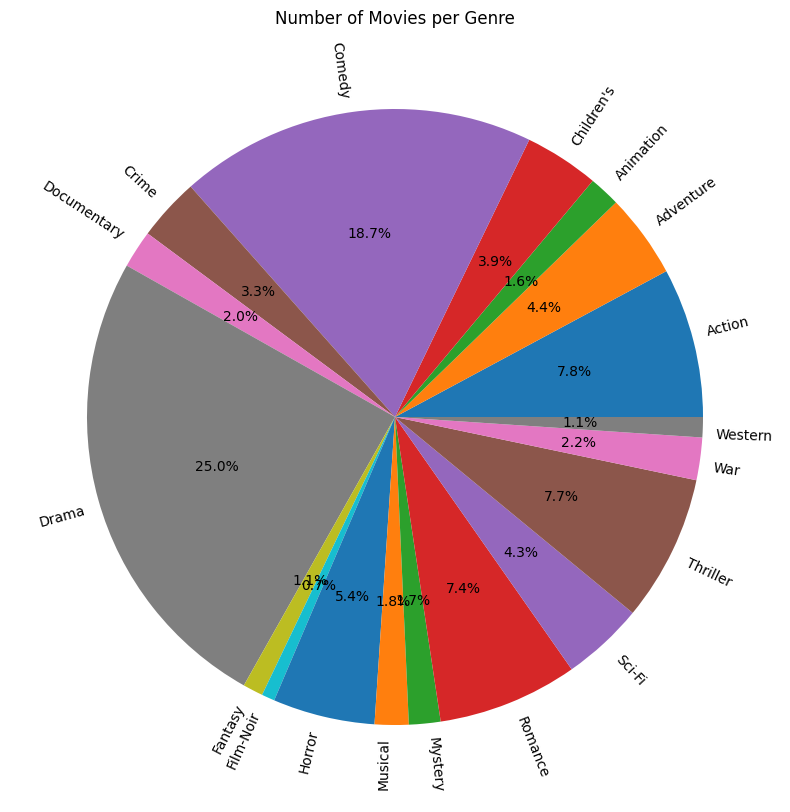

In [29]:
# Plot the % of movies by genre

plt.figure(figsize=(50, 10))
plt.pie(movies_per_genre, labels=movies_per_genre.index, autopct='%.1f%%', labeldistance=1.04, rotatelabels=True)

plt.title('Number of Movies per Genre')
plt.show()

Drama is the most common genre, followed by comedy and so on ...

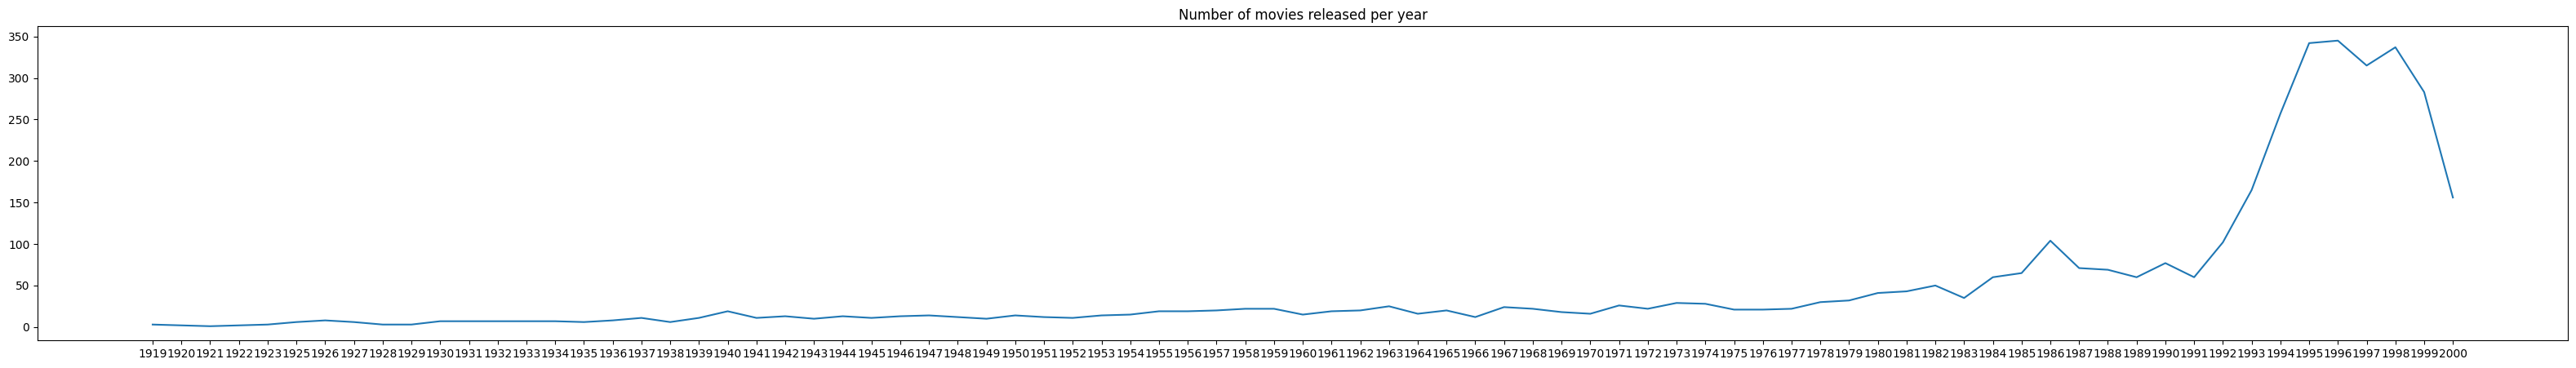

Max No.of Movies Relesed = 345
Year = 1996


In [30]:
# Plot the # of movies released each year

plt.figure(figsize=(40, 5))
plt.plot(movies.groupby('year').title.count())
plt.title('Number of movies released per year')
plt.show()
a=movies.groupby('year').title.count()
print('Max No.of Movies Relesed =',a.max())
for i in a.index:
    if a[i] == a.max():
        print('Year =',i)

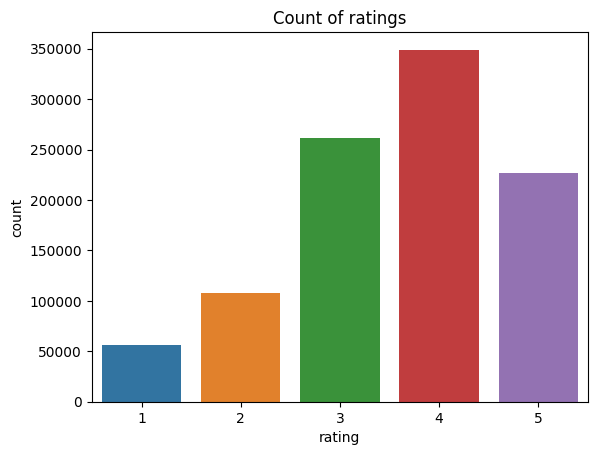

In [31]:
# Plot a histogram of the ratings data
sns.countplot(data=ratings, x='rating')
plt.title('Count of ratings')
plt.show()

The most common rating given to movies is 4.0 stars followed by 3.0 stars and so on ...

# How to compute the recommendations for one user

**1. First, we choose the movies features that we are going to use to compute similarity between different movies.**

* Genres: each genre is a feature
    
* Release year
    
* Both together
    
* We can extract other features (by adding infos from imdb; other features like actors, directors, and plot keywords can also be useful, or using tags)
    
**2. Then, we fix the similarity metric that measures how similar two movies are, based on their feature vectors.**

   * For genres as features: Cosine similarity metric
    
   * For release year as feature: Euclidian distance, Exponential Decay Similarity Metric.
    
   The choice of similarity metric depends on the features being used. For example, cosine similarity works well for genre features because they are binary (a movie either has a particular genre or it doesn't), while Euclidean distance may work better for continuous features like release year.
    
**3. Next, for each movie that the user has rated, we need to find the top K most similar movies based on the computed similarities. We are going to use the KNeighborsClassifier.**

The choice of k (the number of nearest neighbors to consider) can also affect the recommendations. A larger k may result in more diverse recommendations, while a smaller k may result in more similar recommendations.

**4. We combine the recommendations from all of the movies that the user has rated to create a list of recommended movies for the user.**

The method for combining recommendations from different movies can also affect the recommendations. One common approach is to simply aggregate the recommendations and sort them by some relevance metric.

**5. Sort the recommended movies by some relevance metric: similarity score weighted by user ratings.**
For example, user rated high movie1 and rated low movie2, then it is only logical that he gets recommended to more movies similar to movie1.


# Data preparation


In [32]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [33]:
ratings.drop(['timestamp'], axis=1, inplace= True)

In [34]:
# Drop unused attributes
movies_features = movies.drop(['title', 'genres'], axis=1, inplace=False)

In [35]:
# Merge with genres
movies_features = pd.merge(movies_features, genres_df, left_index=True, right_index=True)

In [36]:
movies_features.tail()

,movieId,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
3878,3948,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3882,3952,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


# Content based filtering, with Features = Genres

In [37]:
movies_features.iloc[:, 2:]

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [38]:
model = NearestNeighbors(n_neighbors=10, metric='cosine')
model.fit(movies_features.iloc[:, 2:])

NearestNeighbors(metric='cosine', n_neighbors=10)

In [39]:
# Define a function to recommend movies based on a given movie
def recommend_movies(movie_idx, features, model):
    # Find the n nearest neighbors based on the cosine similarity
    distances, indices = model.kneighbors(features)

    # Get the attributes of the nearest neighbor movies
    recommended_movies = pd.DataFrame([movies.iloc[idx] for idx in indices.flatten()])
    recommended_movies['distance'] = distances.flatten()

    # Print the recommended movies
#     print(movies.loc[movie_idx])
#     print("Movies similar to", find_title_by_idx(movie_idx), ":\n")
#     print(recommended_movies)        
    # Return the recommended movies
    return recommended_movies

In [40]:
def find_idx_by_title(title):
    idx = movies[movies['title'] == title].index
    return idx[0]

In [41]:
def find_title_by_idx(idx):
    title = movies.loc[idx]['title']
    return title

In [42]:
# Test recs on "Toy Story (1995)" :
index = find_idx_by_title("Toy Story (1995)")

recommend_movies(index, pd.DataFrame(movies_features.iloc[index, 2:]).transpose(), model)

,movieId,title,genres,year,distance
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1999,0.0
2285,2354,"Rugrats Movie, The (1998)",Animation|Children's|Comedy,1998,0.0
3685,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,2000,0.0
3682,3751,Chicken Run (2000),Animation|Children's|Comedy,2000,0.0
3542,3611,Saludos Amigos (1943),Animation|Children's|Comedy,1943,0.0
2073,2142,"American Tail: Fievel Goes West, An (1991)",Animation|Children's|Comedy,1991,0.0
2072,2141,"American Tail, An (1986)",Animation|Children's|Comedy,1986,0.0
1050,1064,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy,1996,0.0
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.0
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,0.0


As you can see, all the recommended movies have similar genres as the movie "Toy Story (1995)"


# Content based filtering, with Features = Release year

In [43]:
model_1 = NearestNeighbors(n_neighbors=10, metric='euclidean')
model_1.fit(pd.DataFrame(movies_features.iloc[:, 1]))

NearestNeighbors(metric='euclidean', n_neighbors=10)

In [44]:
pd.DataFrame(movies_features.iloc[:, 1])

,year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
3878,2000
3879,2000
3880,2000
3881,2000


In [45]:
pd.DataFrame(movies_features.iloc[index, 1:2]).transpose()

,year
0,1995


In [46]:
# Test recs on "Toy Story (1995)" :
index = find_idx_by_title("Toy Story (1995)")

recommend_movies(index, pd.DataFrame(movies_features.iloc[index, 1:2]).transpose(), model_1)

,movieId,title,genres,year,distance
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0.0
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,0.0
5,6,Heat (1995),Action|Crime|Thriller,1995,0.0
8,9,Sudden Death (1995),Action,1995,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0.0
4,5,Father of the Bride Part II (1995),Comedy,1995,0.0
6,7,Sabrina (1995),Comedy|Romance,1995,0.0
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.0
14,15,Cutthroat Island (1995),Action|Adventure|Romance,1995,0.0
7,8,Tom and Huck (1995),Adventure|Children's,1995,0.0


# Content based filtering, with Features = genres + release year

In [47]:
# Cosine sim
def compute_genre_similarity(movie1, movie2):
    genres1 = movie1[1:]
    genres2 = movie2[1:]
#     sumxx, sumxy, sumyy = 0, 0, 0
#     for i in range(len(genres1)):
#         x = genres1[i]
#         y = genres2[i]
#         sumxx += x * x
#         sumyy += y * y
#         sumxy += x * y
        
    #return (1 - sumxy/math.sqrt(sumxx*sumyy))

    return sklearn.metrics.pairwise.cosine_distances(genres1.reshape(1, -1), genres2.reshape(1, -1))

In [48]:
# exponential decay similarity score
def compute_year_similarity(x1, x2):
    diff = abs(x1[0] - x2[0])
    sim = math.exp(-diff / 10.0)
    #print(sklearn.metrics.pairwise.euclidean_distances(x1[0].reshape(1, -1), x2[0].reshape(1, -1)))
    #print(1 - sim)
    return (1 - sim)

The next function can be a good starting point to compute similarity between two movies based on genres and release year. However, it depends on the specific use case and the weight given to each similarity measure.


Adding these scores together assumes that they have equal weight in determining the overall similarity between two movies. This may not be appropriate in all cases, as the importance of genres and release years in determining similarity can vary depending on the context.

Multiplying them means that the final similarity score will be affected by the difference in magnitude between the genre similarity score and the year similarity score.

In [49]:
def compute_distance(x1, x2):
    genre_similarity= compute_genre_similarity(x1, x2)
    year_similarity= compute_year_similarity(x1, x2)

    #return year_similarity + genre_similarity
    #return year_similarity * genre_similarity
    return (year_similarity*0.2 + genre_similarity*0.8)


In [50]:
movies_features.head()

,movieId,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
pd.DataFrame(movies_features.iloc[:, 1:])

,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [52]:
nn = NearestNeighbors(n_neighbors=10, metric=compute_distance)
nn.fit(pd.DataFrame(movies_features.iloc[:, 1:]))

NearestNeighbors(metric=<function compute_distance at 0x7fd462f889d0>,
                 n_neighbors=10)

In [53]:
# Test recs on "Toy Story (1995)" :
index = find_idx_by_title("Toy Story (1995)")

recommend_movies(index, pd.DataFrame(movies_features.iloc[index, 1:]).transpose(), nn)

,movieId,title,genres,year,distance
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.000000
1050,1064,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy,1996,0.019033
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,0.051836
2285,2354,"Rugrats Movie, The (1998)",Animation|Children's|Comedy,1998,0.051836
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1999,0.065936
2073,2142,"American Tail: Fievel Goes West, An (1991)",Animation|Children's|Comedy,1991,0.065936
3685,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,2000,0.078694
3682,3751,Chicken Run (2000),Animation|Children's|Comedy,2000,0.078694
236,239,"Goofy Movie, A (1995)",Animation|Children's|Comedy|Romance,1995,0.107180
2072,2141,"American Tail, An (1986)",Animation|Children's|Comedy,1986,0.118686


The movies recommended are pretty similar to the input movie, in terms of genres and release decade (year).

# Recommend movies for user

In [75]:
user_id = 1664

In [69]:
print(ratings['userId'].value_counts())

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: userId, Length: 6040, dtype: int64


In [76]:
def get_ratings_per_user (user_id):
    # Get all rows corresponding to the user_id
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Drop userId col
    user_ratings = user_ratings.drop(['userId'], axis=1)
    
    return user_ratings

In [77]:
ratings_per_user = get_ratings_per_user(user_id)

In [78]:
ratings_per_user

,movieId,rating
274843,1,5
274844,1265,2
274845,2092,2
274846,3253,5
274847,2858,5
274848,3809,4
274849,3114,2
274850,2321,4
274851,2355,3
274852,2506,3


In [79]:
rated_movies = pd.merge(ratings_per_user, movies, on='movieId')

In [80]:
rated_movies

,movieId,rating,title,genres,year
0,1,5,Toy Story (1995),Animation|Children's|Comedy,1995
1,1265,2,Groundhog Day (1993),Comedy|Romance,1993
2,2092,2,"Return of Jafar, The (1993)",Animation|Children's|Musical,1993
3,3253,5,Wayne's World (1992),Comedy,1992
4,2858,5,American Beauty (1999),Comedy|Drama,1999
5,3809,4,What About Bob? (1991),Comedy,1991
6,3114,2,Toy Story 2 (1999),Animation|Children's|Comedy,1999
7,2321,4,Pleasantville (1998),Comedy,1998
8,2355,3,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998
9,2506,3,"Other Sister, The (1999)",Comedy|Drama|Romance,1999


Looks like this user likes comedy and movies from the (80s-90s)

In [81]:
def find_index_by_id(movie_id):
    idx = movies[movies['movieId'] == movie_id].index
    return idx[0]

In [82]:
recs = pd.DataFrame()
for index, row in ratings_per_user.iterrows():
    movie_id = int(row['movieId'])
    rating = row['rating']
    features = pd.DataFrame(movies_features.iloc[find_index_by_id(movie_id), 1:]).transpose()
    recs_by_movie = recommend_movies(movie_id, features, nn)
    # Multiplying by (1/rating), so that movies similar to those high rated get more chance
    # to appear in the top n list.
    # Adding 1 to avoid 0 values (0*1 = 0*5: ratings make no difference in this case)
    # The smaller relevance is, the better recommendation is
    recs_by_movie['relevance'] = (1+recs_by_movie['distance'])*(1/rating) 
    recs = pd.concat([recs, recs_by_movie], ignore_index=True)

In [83]:
recs

,movieId,title,genres,year,distance,relevance
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.000000,0.200000
1,1064,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy,1996,0.019033,0.203807
2,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,0.051836,0.210367
3,2354,"Rugrats Movie, The (1998)",Animation|Children's|Comedy,1998,0.051836,0.210367
4,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1999,0.065936,0.213187
...,...,...,...,...,...,...
195,1381,Grease 2 (1982),Comedy|Musical|Romance,1982,0.225497,0.245099
196,2934,"Love Bewitched, A (El Amor Brujo) (1986)",Musical,1986,0.253347,0.250669
197,1380,Grease (1978),Comedy|Musical|Romance,1978,0.265489,0.253098
198,1057,Everyone Says I Love You (1996),Comedy|Musical|Romance,1996,0.265489,0.253098


In [84]:
bottom_20 = recs.nlargest(20, 'relevance')

In [85]:
bottom_20

,movieId,title,genres,year,distance,relevance
188,3698,"Running Man, The (1987)",Action|Adventure|Sci-Fi,1987,2.462587e-01,1.246259
189,3638,Moonraker (1979),Action|Romance|Sci-Fi,1979,2.462587e-01,1.246259
187,1676,Starship Troopers (1997),Action|Adventure|Sci-Fi|War,1997,2.351389e-01,1.235139
185,2641,Superman II (1980),Action|Adventure|Sci-Fi,1980,2.321590e-01,1.232159
186,1376,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi,1986,2.321590e-01,1.232159
184,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1980,2.118364e-01,1.211836
182,1375,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi,1984,1.993552e-01,1.199355
183,1374,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi,1982,1.993552e-01,1.199355
181,2642,Superman III (1983),Action|Adventure|Sci-Fi,1983,1.803227e-01,1.180323
170,699,To Cross the Rubicon (1991),Drama,1991,0.000000e+00,1.000000


Our recommender system is aware that this user hates Sci-Fi movies

In [86]:
top_10 = recs.nsmallest(10, 'relevance')

In [87]:
top_10

,movieId,title,genres,year,distance,relevance
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.0,0.2
30,2302,My Cousin Vinny (1992),Comedy,1992,0.0,0.2
31,751,Careful (1992),Comedy,1992,0.0,0.2
32,3043,Meatballs 4 (1992),Comedy,1992,0.0,0.2
33,298,Pushing Hands (1992),Comedy,1992,0.0,0.2
34,1171,Bob Roberts (1992),Comedy,1992,0.0,0.2
35,3669,Stay Tuned (1992),Comedy,1992,0.0,0.2
36,3253,Wayne's World (1992),Comedy,1992,0.0,0.2
37,3263,White Men Can't Jump (1992),Comedy,1992,0.0,0.2
38,3243,Encino Man (1992),Comedy,1992,0.0,0.2


In [88]:
top_20 = recs.nsmallest(20, 'relevance')

In [89]:
top_20

,movieId,title,genres,year,distance,relevance
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0.000000e+00,0.2
30,2302,My Cousin Vinny (1992),Comedy,1992,0.000000e+00,0.2
31,751,Careful (1992),Comedy,1992,0.000000e+00,0.2
32,3043,Meatballs 4 (1992),Comedy,1992,0.000000e+00,0.2
33,298,Pushing Hands (1992),Comedy,1992,0.000000e+00,0.2
34,1171,Bob Roberts (1992),Comedy,1992,0.000000e+00,0.2
35,3669,Stay Tuned (1992),Comedy,1992,0.000000e+00,0.2
36,3253,Wayne's World (1992),Comedy,1992,0.000000e+00,0.2
37,3263,White Men Can't Jump (1992),Comedy,1992,0.000000e+00,0.2
38,3243,Encino Man (1992),Comedy,1992,0.000000e+00,0.2
